In [70]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
import os
import html
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from sklearn.preprocessing import LabelEncoder

In [71]:
dir_path = os.getcwd()
data_dir = os.path.join(dir_path, 'data')
nltk_data_dir= os.path.join(data_dir, 'nltk')

nltk.download('stopwords', download_dir=nltk_data_dir)
nltk.download('punkt', download_dir=nltk_data_dir)
nltk.download('vader_lexicon', download_dir=nltk_data_dir)

num_epochs=20
##--Disabling the warnings for better notebook visibility
import warnings
warnings.simplefilter('ignore')

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 23

#Flags and values
imbalanced_flag=False
neutral_lower_limit=4
neutral_upper_limit=7

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

[nltk_data] Downloading package stopwords to C:\Users\Juan
[nltk_data]     Ma\UWaterloo\ECE 657A\Project\data\nltk...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Juan
[nltk_data]     Ma\UWaterloo\ECE 657A\Project\data\nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Juan
[nltk_data]     Ma\UWaterloo\ECE 657A\Project\data\nltk...
[nltk_data]   Package vader_lexicon is already up-to-date!


When looking at the data, it can be seen that it is given as two datasets, one for train and one for test. It is better to merge them together and do the train-test split after they have been preprocessed. The datasets include the index for the file, which can be used for this work. The reviews column includes strings that are wrapped with a double quote, which do not allow for the replacement of the apostrophe in the Preprocessing step further below. Therefore, it is considered a good idea to remove them during the load of the dataset.

In [72]:
#Load data
rm_quote = lambda x: x.replace('"', '')
df_drugs_train = pd.read_csv(os.path.join(data_dir, 'drugsComTrain_raw.tsv'), sep='\t', index_col=0, converters={'review': rm_quote})
df_drugs_train = df_drugs_train.reset_index(drop=True)

df_drugs_test = pd.read_csv(os.path.join(data_dir, 'drugsComTest_raw.tsv'), sep='\t', index_col=0, converters={'review': rm_quote})
df_drugs_test = df_drugs_test.reset_index(drop=True)

# Preprocessing

In [75]:
#Contractions removal, based on https://stackoverflow.com/a/47091490
import re   
def decontracted(phrase):
    # specific
    phrase = re.sub("\d+", "", phrase) #Deletes all digits
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

unescaper = lambda x: decontracted(html.unescape(x))
df_drugs_train['review']=df_drugs_train['review'].apply(unescaper)
df_drugs_test['review']=df_drugs_test['review'].apply(unescaper)

lbs lost in . months using saxenda (dose between .-.) & following doctor's guidelines for eating.  Did not exercise during the months. I was losing except for physical therapy x a week for back.  I am at a good weight for me ('", , age ) and have been maintaining within -lbs for about  mos. now but still using saxenda.  Have not been super strict with diet but not going crazy either.  Added light weight training and walking on treadmill - days a week right before Christmas.  If I overeat a day or  I go back to watching and the weight comes right back down.  Thankfully husband's insurance covers drug because mine does not.  Feel great, cholesterol & blood pressure good again, back is better, and clothes fit.


In [76]:
#Rating labeling
def rating_labeler(val):
    if val>neutral_lower_limit:
        if val<neutral_upper_limit:
            lbl="Neutral"
        else:
            lbl="Positive"
    else:
        lbl="Negative"
    return lbl

df_drugs_train_labeled= df_drugs_train.copy()
df_drugs_train_labeled['rating_label'] = df_drugs_train_labeled['rating'].apply(lambda row: rating_labeler(row))

df_drugs_test_labeled= df_drugs_test.copy()
df_drugs_test_labeled['rating_label'] = df_drugs_test_labeled['rating'].apply(lambda row: rating_labeler(row))

,drugName,condition,review,rating,date,usefulCount,rating_label
0,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9.0,"May 20, 2012",27,Positive
1,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8.0,"April 27, 2010",192,Positive
2,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5.0,"December 14, 2009",17,Neutral
3,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8.0,"November 3, 2015",10,Positive
4,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9.0,"November 27, 2016",37,Positive
5,Cialis,Benign Prostatic Hyperplasia,nd day on mg started to work with rock hard er...,2.0,"November 28, 2015",43,Negative
6,Levonorgestrel,Emergency Contraception,"He pulled out, but he cummed a bit in me. I to...",1.0,"March 7, 2017",5,Negative
7,Aripiprazole,Bipolar Disorde,Abilify changed my life. There is hope. I was ...,10.0,"March 14, 2015",32,Positive
8,Keppra,Epilepsy,I Ve had nothing but problems with the Keppe...,1.0,"August 9, 2016",11,Negative
9,Ethinyl estradiol / levonorgestrel,Birth Control,I had been on the pill for many years. When my...,8.0,"December 8, 2016",1,Positive


In [86]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# CNN without GloVe Embedding

In [88]:
#Train test without tokenization
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

stp_words=stopwords.words('english')
def stopword_removal(text, words):
    """
    :param title: string you want to split.
    :param words: list of words you are looking to match.
    :param randoms: list of random words to replace with words.
    :return: new title
    """
    text=text.lower()
    text=' '.join(['' if word in words else word 
                    for word in text.split()])
    text=re.sub(' +', ' ', text)
    text=text.lstrip()
    return text

stp_word = lambda x: stopword_removal(x, stp_words)

df_drugs_train_labeled['review'] = df_drugs_train_labeled['review'].str.lower()
df_drugs_train_labeled['review'] = df_drugs_train_labeled['review'].apply(stp_word)
df_drugs_train_labeled['review'] = df_drugs_train_labeled['review'].str.strip()

df_drugs_test_labeled['review'] = df_drugs_test_labeled['review'].str.lower()
df_drugs_test_labeled['review'] = df_drugs_test_labeled['review'].apply(stp_word)
df_drugs_test_labeled['review'] = df_drugs_test_labeled['review'].str.strip()


X_train = df_drugs_train_labeled['review']
X_test = df_drugs_test_labeled['review']

y_train = df_drugs_train_labeled['rating_label']
y_test = df_drugs_test_labeled['rating_label']


# encode class values as integers
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
y_train_dummy = np_utils.to_categorical(y_train_enc)
y_test_dummy = np_utils.to_categorical(y_test_enc)

X_train, X_val, y_train_dummy, y_val_dummy = train_test_split(X_train, y_train_dummy, test_size=0.2,
                                                  random_state=1, stratify = df_drugs_train_labeled['rating_label'])

In [89]:
#Tokenization and sequencing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

sequences = tokenizer.texts_to_sequences(X_train)

#----------------------
length = []
for x in X_train:
    length.append(len(x.split()))
mxlen = max(length)
#----------------------
X_train_seq = pad_sequences(sequences, maxlen=mxlen)
#----------------------
sequences_val = tokenizer.texts_to_sequences(X_val)
X_val_seq = pad_sequences(sequences_val, maxlen=mxlen)
#----------------------
sequences_test = tokenizer.texts_to_sequences(X_test)
X_test_seq = pad_sequences(sequences_test, maxlen=mxlen)

In [91]:
#Model creation, based on [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
#----------------------
from keras.layers import Input, Dense, concatenate, Activation, LSTM, CuDNNLSTM
from keras.models import Model
from keras.metrics import top_k_categorical_accuracy

drugs_input = Input(shape=(mxlen,), dtype='int32')

drugs_encoder = Embedding(10000, 200, input_length=mxlen)(drugs_input)
drugs_lstm=(CuDNNLSTM(200, return_sequences=True))(drugs_encoder)
drugs_lstm=(CuDNNLSTM(200))(drugs_lstm)
drugs_lstm=(Dropout(0.5))(drugs_lstm)
output = (Dense(3, activation='softmax'))(drugs_lstm)
model = Model(inputs=[drugs_input], outputs=[output])


model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['categorical_crossentropy', 'accuracy'])
model.summary()

from keras.utils import plot_model
plot_model(model, to_file='fig_LSTM_Paper_Model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 200)         2000000   
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 1000, 200)         321600    
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 200)               321600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 603       
Total params: 2,643,803
Trainable params: 2,643,803
Non-trainable params: 0
_________________________________________________________________


In [62]:
#Train the model
from keras.callbacks import ModelCheckpoint
filepath="LSTM_Multi_Paper_best_weights_SW_NoEmb.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model.fit(X_train_seq, y_train_dummy, batch_size=32, epochs=num_epochs,
                     validation_data=(X_val_seq, y_val_dummy), callbacks = [checkpoint])
model_no_emb = model
#model_no_emb.save('LSTM_Multi_Paper_best_weights_NoEmb-Full.h5')


Train on 129037 samples, validate on 32260 samples
Epoch 1/20
129037/129037 [==============================] - 604s 5ms/step - loss: 0.4396 - categorical_crossentropy: 0.4396 - acc: 0.8365 - val_loss: 0.4914 - val_categorical_crossentropy: 0.4914 - val_acc: 0.8163

Epoch 00001: val_acc improved from -inf to 0.81627, saving model to LSTM_Multi_Paper_best_weights_SW_NoEmb.01-0.8163.hdf5
Epoch 2/20
129037/129037 [==============================] - 607s 5ms/step - loss: 0.3287 - categorical_crossentropy: 0.3287 - acc: 0.8805 - val_loss: 0.4774 - val_categorical_crossentropy: 0.4774 - val_acc: 0.8296

Epoch 00002: val_acc improved from 0.81627 to 0.82960, saving model to LSTM_Multi_Paper_best_weights_SW_NoEmb.02-0.8296.hdf5
Epoch 3/20
129037/129037 [==============================] - 613s 5ms/step - loss: 0.2380 - categorical_crossentropy: 0.2380 - acc: 0.9156 - val_loss: 0.5088 - val_categorical_crossentropy: 0.5088 - val_acc: 0.8378

Epoch 00003: val_acc improved from 0.82960 to 0.83779, sa

In [23]:
#Create a copy of the model
model_no_emb = model

In [25]:
#Print the accuracy and loss
np.set_printoptions(precision=4, suppress=True)
eval_results = model_no_emb.evaluate(X_test_seq, y_test_dummy) 
print("\nLoss, accuracy on test data: ")
print("%0.4f %0.2f%%" % (eval_results[0], \
  eval_results[2]*100))

53766/53766 [==============================] - 74s 1ms/step

Loss, accuracy on test data: 
1.0513 86.17%


In [26]:
#Save the model
#model_no_emb.save('LSTM_Multi_Paper_best_weights_NoEmb-Full.h5')

In [27]:
# NN plotting function. Based on https://realpython.com/python-keras-text-classification/
import matplotlib.pyplot as plt

def plot_history(mod):
    acc = mod.history.history['acc']
    val_acc = mod.history.history['val_acc']
    loss = mod.history.history['loss']
    val_loss = mod.history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(18, 10))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc = 'best')
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training Loss')
    plt.plot(x, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc = 'best')

In [28]:
#Plot the accuracy and loss
plot_history(model_no_emb)

AttributeError: 'Model' object has no attribute 'history'

In [24]:
#Pretty print confusion matrix, created by Shaypal5:
# https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    #Created by:
    # Shaypal5
    # https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).print(pd.DataFrame(y_train).head())
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

              precision    recall  f1-score   support

         1.0       0.83      0.79      0.81     13497
         2.0       0.62      0.55      0.58      4829
         3.0       0.90      0.93      0.92     35440

   micro avg       0.86      0.86      0.86     53766
   macro avg       0.78      0.76      0.77     53766
weighted avg       0.86      0.86      0.86     53766



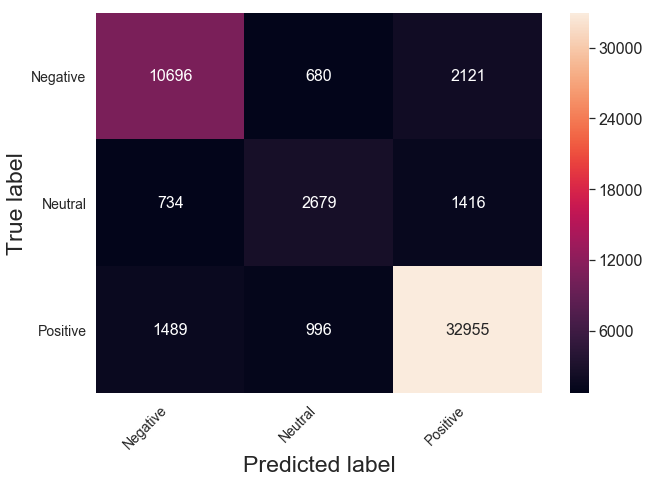

In [67]:
#Print the classification report and the confusion pmatrix
from sklearn.metrics import classification_report
from sklearn import metrics
y_predict = model.predict(X_test_seq)
y_pred = np.zeros_like(y_predict)
y_pred[np.arange(len(y_predict)), y_predict.argmax(1)] = 1

r,_ = y_pred.shape

y_p = np.zeros(r)
y_t = np.zeros(r)

for i in range(r):
    y_p[i] = 1*y_pred[i][0] + 2*y_pred[i][1] + 3*y_pred[i][2]
    y_t[i] = 1*y_test_dummy[i][0] + 2*y_test_dummy[i][1] + 3*y_test_dummy[i][2]



print(classification_report(y_t,y_p))
fig = print_confusion_matrix(metrics.confusion_matrix(y_t,y_p),['Negative', 'Neutral', 'Positive'])

# With Non-trainable GloVe Embedding

In [27]:
EMBEDDING_DIM=100
word_index = tokenizer.word_index

In [28]:
#Compute an index mapping
embeddings_index = {}
f = open(os.path.join(data_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [29]:
#Create the embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [31]:
#Create the model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
#----------------------
from keras.layers import Input, Dense, concatenate, Activation, LSTM, CuDNNLSTM
from keras.models import Model

drugs_input = Input(shape=(mxlen,), dtype='int32')

drugs_encoder = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=mxlen, trainable=False)(drugs_input)
drugs_lstm=(CuDNNLSTM(200, return_sequences=True))(drugs_encoder)
drugs_lstm=(CuDNNLSTM(200))(drugs_lstm)
drugs_lstm=(Dropout(0.5))(drugs_lstm)
output = (Dense(3, activation='softmax'))(drugs_lstm)
model = Model(inputs=[drugs_input], outputs=[output])

model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['categorical_crossentropy', 'accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 100)         4520000   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 1000, 200)         241600    
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 200)               321600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 603       
Total params: 5,083,803
Trainable params: 563,803
Non-trainable params: 4,520,000
____________________________________________________________

In [32]:
#Train the model
from keras.callbacks import ModelCheckpoint
filepath="LSTM_Multi_Paper_best_weights_NoTrainEmb.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model.fit(X_train_seq, y_train_dummy, batch_size=32, epochs=num_epochs,
                     validation_data=(X_val_seq, y_val_dummy), callbacks = [checkpoint])

Train on 129037 samples, validate on 32260 samples
Epoch 1/20
129037/129037 [==============================] - 900s 7ms/step - loss: 0.6579 - categorical_crossentropy: 0.6579 - acc: 0.7435 - val_loss: 0.5906 - val_categorical_crossentropy: 0.5906 - val_acc: 0.7722

Epoch 00001: val_acc improved from -inf to 0.77219, saving model to LSTM_Multi_Paper_best_weights_NoTrainEmb.01-0.7722.hdf5
Epoch 2/20
129037/129037 [==============================] - 1099s 9ms/step - loss: 0.5517 - categorical_crossentropy: 0.5517 - acc: 0.7897 - val_loss: 0.5262 - val_categorical_crossentropy: 0.5262 - val_acc: 0.8000

Epoch 00002: val_acc improved from 0.77219 to 0.79997, saving model to LSTM_Multi_Paper_best_weights_NoTrainEmb.02-0.8000.hdf5
Epoch 3/20
129037/129037 [==============================] - 492s 4ms/step - loss: 0.5060 - categorical_crossentropy: 0.5060 - acc: 0.8074 - val_loss: 0.5194 - val_categorical_crossentropy: 0.5194 - val_acc: 0.8060

Epoch 00003: val_acc improved from 0.79997 to 0.8059

In [67]:
#Create a copy of the model and save it
model_no_train_emb = model
#model_no_train_emb.save('LSTM_Multi_Paper_best_weights_TrainEmb-Full.h5')

In [69]:
#Print the accuracy and loss
np.set_printoptions(precision=4, suppress=True)
eval_results = model_no_train_emb.evaluate(X_test_seq, y_test_dummy) 
print("\nLoss, accuracy on test data: ")
print("%0.4f %0.2f%%" % (eval_results[0], \
  eval_results[2]*100))

53766/53766 [==============================] - 71s 1ms/step

Loss, accuracy on test data: 
1.0746 86.53%


In [ ]:
#Plot the accuracy and loss
plot_history(model_no_train_emb)

              precision    recall  f1-score   support

         1.0       0.81      0.81      0.81     13497
         2.0       0.58      0.53      0.55      4829
         3.0       0.91      0.93      0.92     35440

   micro avg       0.86      0.86      0.86     53766
   macro avg       0.77      0.75      0.76     53766
weighted avg       0.86      0.86      0.86     53766



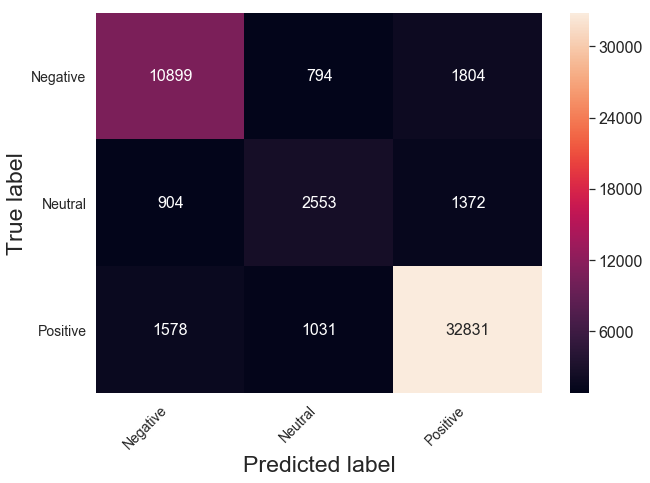

In [36]:
#Print the classification report and the confusion matrix
from sklearn.metrics import classification_report
from sklearn import metrics
y_predict = model.predict(X_test_seq)
y_pred = np.zeros_like(y_predict)
y_pred[np.arange(len(y_predict)), y_predict.argmax(1)] = 1

r,_ = y_pred.shape

y_p = np.zeros(r)
y_t = np.zeros(r)

for i in range(r):
    y_p[i] = 1*y_pred[i][0] + 2*y_pred[i][1] + 3*y_pred[i][2]
    y_t[i] = 1*y_test_dummy[i][0] + 2*y_test_dummy[i][1] + 3*y_test_dummy[i][2]



print(classification_report(y_t,y_p))
# print('Confusion Matrix:')
# print(metrics.confusion_matrix(y_test,y_pred))

###########Ojo este orden no es de las labels
fig = print_confusion_matrix(metrics.confusion_matrix(y_t,y_p),['Negative', 'Neutral', 'Positive'])


# With Trainable GloVe Embedding

In [38]:
#Create the model:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
#----------------------
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model

drugs_input = Input(shape=(mxlen,), dtype='int32')

drugs_encoder = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=mxlen, trainable=True)(drugs_input)
drugs_lstm=(CuDNNLSTM(200, return_sequences=True))(drugs_encoder)
drugs_lstm=(CuDNNLSTM(200))(drugs_lstm)
drugs_lstm=(Dropout(0.5))(drugs_lstm)
output = (Dense(3, activation='softmax'))(drugs_lstm)
model = Model(inputs=[drugs_input], outputs=[output])
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['categorical_crossentropy', 'accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1000, 100)         4520000   
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 1000, 200)         241600    
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 200)               321600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 603       
Total params: 5,083,803
Trainable params: 5,083,803
Non-trainable params: 0
_________________________________________________________________


In [39]:
#Train the model
from keras.callbacks import ModelCheckpoint
filepath="LSTM_Multi_Paper_best_weights_SW_TrainEmb.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model.fit(X_train_seq, y_train_dummy, batch_size=32, epochs=num_epochs,
                     validation_data=(X_val_seq, y_val_dummy), callbacks = [checkpoint])

Train on 129037 samples, validate on 32260 samples
Epoch 1/20
129037/129037 [==============================] - 488s 4ms/step - loss: 0.5862 - categorical_crossentropy: 0.5862 - acc: 0.7779 - val_loss: 0.5216 - val_categorical_crossentropy: 0.5216 - val_acc: 0.8053

Epoch 00001: val_acc improved from -inf to 0.80533, saving model to LSTM_Multi_Paper_best_weights_SW_TrainEmb.01-0.8053.hdf5
Epoch 2/20
129037/129037 [==============================] - 491s 4ms/step - loss: 0.4519 - categorical_crossentropy: 0.4519 - acc: 0.8288 - val_loss: 0.4815 - val_categorical_crossentropy: 0.4815 - val_acc: 0.8178

Epoch 00002: val_acc improved from 0.80533 to 0.81782, saving model to LSTM_Multi_Paper_best_weights_SW_TrainEmb.02-0.8178.hdf5
Epoch 3/20
129037/129037 [==============================] - 495s 4ms/step - loss: 0.3609 - categorical_crossentropy: 0.3609 - acc: 0.8655 - val_loss: 0.4620 - val_categorical_crossentropy: 0.4620 - val_acc: 0.8301

Epoch 00003: val_acc improved from 0.81782 to 0.830

In [40]:
#Create a copy of the model and save it
model_train_emb = model
#model_train_emb.save('LSTM_Multi_Paper_best_weights_TrainEmb-Full.h5')

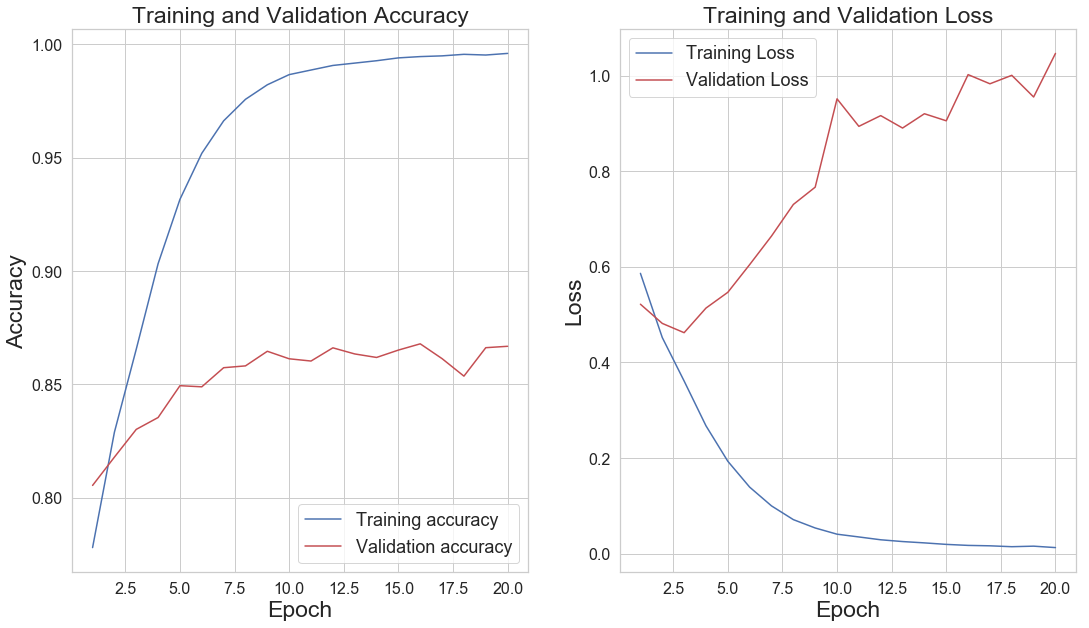

In [42]:
#Plot the accuracy and loss
plot_history(model_train_emb)

In [67]:
#Print the accuracy and loss
np.set_printoptions(precision=4, suppress=True)
eval_results = model_train_emb.evaluate(X_test_seq, y_test_dummy) 
print("\nLoss, accuracy on test data: ")
print("%0.4f %0.2f%%" % (eval_results[0], \
  eval_results[2]*100))

53766/53766 [==============================] - 69s 1ms/step

Loss, accuracy on test data: 
1.0746 86.53%


              precision    recall  f1-score   support

         1.0       0.81      0.82      0.82     13497
         2.0       0.63      0.56      0.59      4829
         3.0       0.91      0.92      0.92     35440

   micro avg       0.87      0.87      0.87     53766
   macro avg       0.78      0.77      0.78     53766
weighted avg       0.86      0.87      0.86     53766



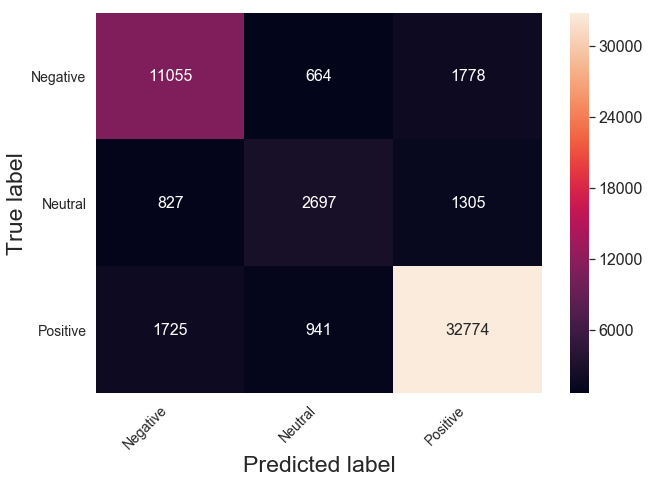

In [44]:
#Create the classification report and confusion matrix
from sklearn.metrics import classification_report
from sklearn import metrics
y_predict = model.predict(X_test_seq)
y_pred = np.zeros_like(y_predict)
y_pred[np.arange(len(y_predict)), y_predict.argmax(1)] = 1

r,_ = y_pred.shape

y_p = np.zeros(r)
y_t = np.zeros(r)

for i in range(r):
    y_p[i] = 1*y_pred[i][0] + 2*y_pred[i][1] + 3*y_pred[i][2]
    y_t[i] = 1*y_test_dummy[i][0] + 2*y_test_dummy[i][1] + 3*y_test_dummy[i][2]



print(classification_report(y_t,y_p))
fig = print_confusion_matrix(metrics.confusion_matrix(y_t,y_p),['Negative', 'Neutral', 'Positive'])

In [ ]:
#Compare the three models
def plot_multi_history(mod1, mod2, mod3):
    acc=[]
    val_acc=[]
    acc.append(mod1.history.history['acc'])
    val_acc.append(mod1.history.history['val_acc'])
    
    acc.append(mod2.history.history['acc'])
    val_acc.append(mod2.history.history['val_acc'])
    
    acc.append(mod3.history.history['acc'])
    val_acc.append(mod3.history.history['val_acc'])
    

    x = range(1, len(acc[0]) + 1)
    models=['No GloVe', 'GloVe with Training', 'GloVe w/o Training']
    alpha_vals=[1, 0.7, 0.6]
    lw_vals=[3,2,1]
    
    plt.figure(figsize=(18, 10))
    for mod_acc, mod, alph, line_w in zip(acc, models, alpha_vals, lw_vals):
        plt.plot(x, mod_acc, color='r', alpha=alph, lw=line_w, label='Train Acc for ' + mod)
    for mod_val_acc, mod, alph, line_w in zip(val_acc, models, alpha_vals, lw_vals):
        plt.plot(x, mod_val_acc, color='b', alpha=alph, lw=line_w, label='Val Acc for ' + mod)
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    
plot_multi_history(model_no_emb, model_train_emb, model_no_train_emb)

# References
[1] Sboev, Aleksandr, et al. "Deep Learning Network Models to Categorize Texts According to Author's Gender and to Identify Text Sentiment." 2016 International Conference on Computational Science and Computational Intelligence (CSCI). IEEE, 2016.